Auto-segmented image saved to: C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots\mango_segmented_auto.png


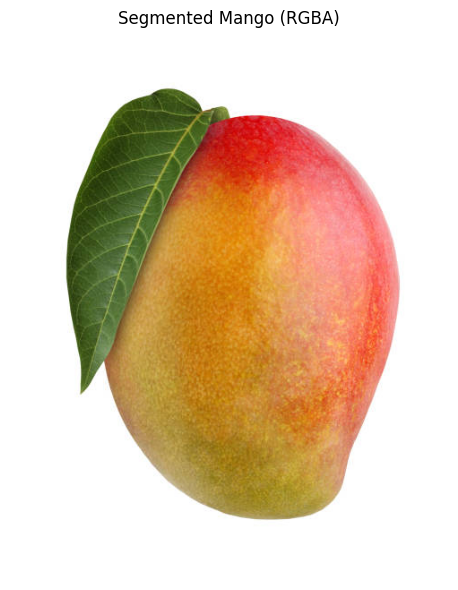

Saved mask images and CSV:
 - C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots\mango_mask_red.png
 - C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots\mango_mask_yellow.png
 - C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots\mango_mask_green.png
 - C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots\mango_mask_black.png
 - C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots\mango_mask_other.png
 - C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots\mango_color_detailed_summary.csv

Summary:
                 color  count  percentage
                  red  34904       23.89
               yellow  85011       58.18
                green   4448        3.04
                black      7        0.00
                other  21758       14.89
total_non_transparent 146128      100.00
Mango Category: Ripe Mango. Saved -> C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots\mango_r

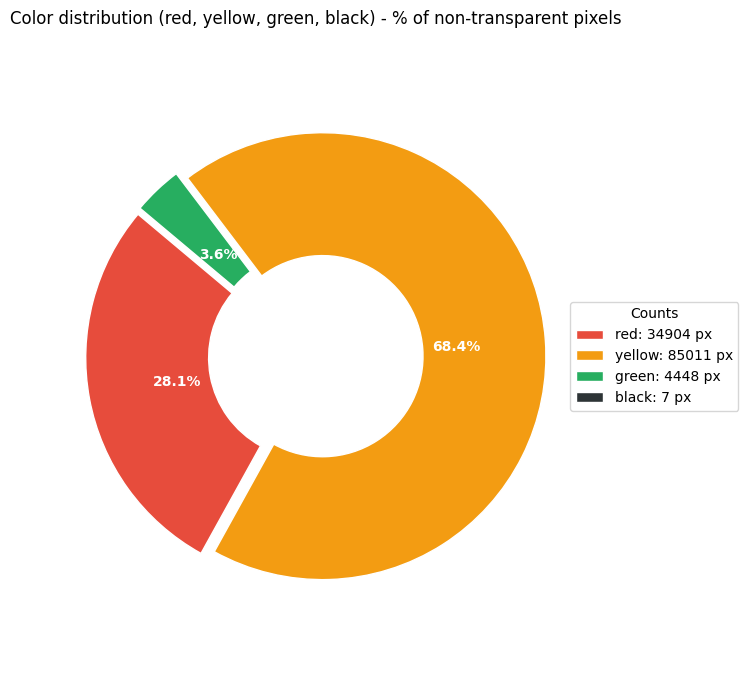

Pie chart saved -> C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots\mango_color_pie.png


In [4]:
from pathlib import Path
from PIL import Image
import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt

INPUT_PATH = Path(r"C:\Users\User\Desktop\PP1\Diseases\Mango_Diseases\sample.jpg")

OUT_DIR = Path(r"C:\Users\User\Desktop\PP1\Diseases\Mango_Harvesting\segmented_plots")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Outputs
OUT_SEGMENTED = OUT_DIR / "mango_segmented_auto.png"
OUT_RED = OUT_DIR / "mango_mask_red.png"
OUT_YELLOW = OUT_DIR / "mango_mask_yellow.png"
OUT_GREEN = OUT_DIR / "mango_mask_green.png"
OUT_BLACK = OUT_DIR / "mango_mask_black.png"
OUT_OTHER = OUT_DIR / "mango_mask_other.png"
OUT_CSV = OUT_DIR / "mango_color_detailed_summary.csv"
OUT_PIE = OUT_DIR / "mango_color_pie.png"
OUT_RIPENESS = OUT_DIR / "mango_ripeness.txt"

# --- Color classification rules (HSV) ---
COLOR_RULES = {
    "black":  {"v_max": 50},  # low value -> black
    "red":    {"h_ranges": [(0, 10), (170, 179)], "s_min": 80, "v_min": 50},
    "yellow": {"h_ranges": [(15, 45)], "s_min": 60, "v_min": 60},
    "green":  {"h_ranges": [(35, 90)], "s_min": 60, "v_min": 50},
}

# --- Utilities ---
def ensure_path_ok(p: Path):
    p.parent.mkdir(parents=True, exist_ok=True)
    return p

def auto_segment_rgb_to_rgba(rgb_bgr):
    """
    Run GrabCut on the BGR image (OpenCV format) and return an RGBA numpy array.
    This uses a center-anchored rectangle and some morphological smoothing.
    """
    img = rgb_bgr.copy()
    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)

    # rectangle tuned to include the subject and exclude most borders
    rect = (int(w*0.06), int(h*0.02), max(10, int(w*0.88)), max(10, int(h*0.94)))
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 6, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')

    # morphological smoothing & hole fill
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, k, iterations=2)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, k, iterations=1)

    # soften edges
    mask_blur = cv2.GaussianBlur(mask2.astype(np.float32), (7,7), 0)
    mask_final = (mask_blur > 0.12).astype(np.uint8)

    # build RGBA (input is BGR -> convert to RGB)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rgba = np.dstack((rgb, (mask_final * 255).astype(np.uint8)))
    return rgba, mask_final

def load_image_as_rgba(path: Path):
    """Load path; if RGB, run auto-segmentation; return RGBA numpy array and bool segmented_flag."""
    if not path.exists():
        raise FileNotFoundError(f"Input file not found: {path}")
    pil = Image.open(path)
    if pil.mode == "RGBA":
        arr = np.array(pil)  # H x W x 4
        return arr, False  # already has alpha, no auto-segmentation performed
    # Convert to BGR for OpenCV processing
    pil_rgb = pil.convert("RGB")
    bgr = cv2.cvtColor(np.array(pil_rgb), cv2.COLOR_RGB2BGR)
    rgba, mask_final = auto_segment_rgb_to_rgba(bgr)
    return rgba, True

def hue_in_ranges(h_channel, ranges):
    out = np.zeros_like(h_channel, dtype=bool)
    for (lo, hi) in ranges:
        if lo <= hi:
            out |= (h_channel >= lo) & (h_channel <= hi)
        else:
            out |= (h_channel >= lo) | (h_channel <= hi)
    return out

# ---- Main classification / saving / plotting functions (same logic as yours) ----
def classify_pixels_and_save_masks(rgba_arr):
    rgb = rgba_arr[:, :, :3].astype(np.uint8)
    alpha = rgba_arr[:, :, 3].astype(np.uint8)
    mask_non_transparent = alpha > 0
    total = int(mask_non_transparent.sum())
    if total == 0:
        raise ValueError("No non-transparent pixels found in input image after segmentation.")

    # HSV via OpenCV (expects BGR)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    h = hsv[:, :, 0]
    s = hsv[:, :, 1]
    v = hsv[:, :, 2]

    labels = np.full(h.shape, "other", dtype=object)

    # black
    v_max = COLOR_RULES["black"]["v_max"]
    is_black = (v <= v_max) & mask_non_transparent
    labels[is_black] = "black"

    # red
    rrule = COLOR_RULES["red"]
    is_red = hue_in_ranges(h, rrule["h_ranges"]) & (s >= rrule["s_min"]) & (v >= rrule["v_min"]) & mask_non_transparent
    labels[is_red & (labels != "black")] = "red"

    # yellow
    yrule = COLOR_RULES["yellow"]
    is_yellow = hue_in_ranges(h, yrule["h_ranges"]) & (s >= yrule["s_min"]) & (v >= yrule["v_min"]) & mask_non_transparent
    labels[is_yellow & (labels != "black") & (labels != "red")] = "yellow"

    # green
    grule = COLOR_RULES["green"]
    is_green = hue_in_ranges(h, grule["h_ranges"]) & (s >= grule["s_min"]) & (v >= grule["v_min"]) & mask_non_transparent
    labels[is_green & (labels != "black") & (labels != "red") & (labels != "yellow")] = "green"

    labels[~mask_non_transparent] = "transparent"

    # save per-color RGBA masks
    def save_mask_for(label_name, out_path):
        H, W = labels.shape
        out = np.zeros((H, W, 4), dtype=np.uint8)
        match = labels == label_name
        if match.sum() > 0:
            out[match, :3] = rgba_arr[match, :3]
            out[match, 3] = rgba_arr[match, 3]
        Image.fromarray(out).save(str(out_path))

    save_mask_for("red", OUT_RED)
    save_mask_for("yellow", OUT_YELLOW)
    save_mask_for("green", OUT_GREEN)
    save_mask_for("black", OUT_BLACK)
    save_mask_for("other", OUT_OTHER)

    # summary CSV
    unique, counts = np.unique(labels[labels != "transparent"], return_counts=True)
    counts_dict = dict(zip(unique, counts))
    for k in ["red","yellow","green","black","other"]:
        counts_dict.setdefault(k, 0)
    rows = []
    for k in ["red","yellow","green","black","other"]:
        cnt = int(counts_dict[k])
        pct = (cnt / total) * 100 if total>0 else 0.0
        rows.append({"color": k, "count": cnt, "percentage": round(pct, 2)})
    rows.append({"color":"total_non_transparent","count":total,"percentage":100.0})
    df = pd.DataFrame(rows)
    df.to_csv(str(OUT_CSV), index=False)

    return df, labels, total

def plot_pie_chart_fixed(df_counts, out_path):
    # build df for desired colors
    df = df_counts[df_counts['color'].isin(['red','yellow','green','black'])].copy()
    for c in ['red','yellow','green','black']:
        if c not in df['color'].values:
            df = pd.concat([df, pd.DataFrame([{'color':c,'count':0,'percentage':0.0}])], ignore_index=True)
    df = df.set_index('color').loc[['red','yellow','green','black']].reset_index()
    sizes = df['percentage'].values
    counts = df['count'].values
    labels = df['color'].values
    color_map = {'red':'#e74c3c','yellow':'#f39c12','green':'#27ae60','black':'#2d3436'}
    colors = [color_map[c] for c in labels]
    explode = [0.03 if pct>0 else 0 for pct in sizes]
    plt.figure(figsize=(7,7))
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=None,
        autopct=lambda pct: f"{pct:.1f}%" if pct>0 else "",
        startangle=140,
        colors=colors,
        explode=explode,
        pctdistance=0.6,
        wedgeprops=dict(width=0.55, edgecolor='white')
    )
    for txt in autotexts:
        txt.set_color('white'); txt.set_fontsize(10); txt.set_weight('bold')
    legend_labels = [f"{lab}: {cnt} px" for lab, cnt in zip(labels, counts)]
    plt.legend(wedges, legend_labels, title="Counts", loc="center left", bbox_to_anchor=(1,0,0.5,1))
    plt.title("Color distribution (red, yellow, green, black) - % of non-transparent pixels")
    plt.axis('equal'); plt.tight_layout()
    plt.savefig(str(out_path), dpi=200); plt.show()

def determine_ripeness_from_df(df_counts):
    d = {row['color']: row['percentage'] for row in df_counts.to_dict(orient='records')}
    red_pct = d.get('red',0.0); yellow_pct = d.get('yellow',0.0); green_pct = d.get('green',0.0); black_pct = d.get('black',0.0)
    if black_pct > 10.0:
        return "Spoiled Mango"
    if (red_pct + yellow_pct) > 60.0:
        return "Ripe Mango"
    if green_pct > 50.0:
        return "Raw Mango"
    return "Uncertain / Partially ripe"

# -------------------- Run pipeline --------------------
def main():
    ensure_path_ok(OUT_SEGMENTED)
    rgba_arr, auto_segmented = load_image_as_rgba(INPUT_PATH)
    # if auto-segmented, save segmented RGBA for user's reference
    if auto_segmented:
        Image.fromarray(rgba_arr).save(str(OUT_SEGMENTED))
        print(f"Auto-segmented image saved to: {OUT_SEGMENTED}")
    else:
        print("Input image already had alpha; skipping auto-segmentation.")

    # --- SHOW SEGMENTED IMAGE (RGBA) ---
    plt.figure(figsize=(6, 6))
    plt.imshow(rgba_arr)
    plt.title("Segmented Mango (RGBA)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()    

    # classification + masks + CSV
    df, labels, total = classify_pixels_and_save_masks(rgba_arr)
    print("Saved mask images and CSV:")
    print(f" - {OUT_RED}")
    print(f" - {OUT_YELLOW}")
    print(f" - {OUT_GREEN}")
    print(f" - {OUT_BLACK}")
    print(f" - {OUT_OTHER}")
    print(f" - {OUT_CSV}")
    print("\nSummary:\n", df.to_string(index=False))

    # ripeness decision
    verdict = determine_ripeness_from_df(df)
    with open(OUT_RIPENESS, "w", encoding="utf-8") as f:
        f.write(verdict + "\n")
    print(f"Mango Category: {verdict}. Saved -> {OUT_RIPENESS}")

    # pie chart
    plot_pie_chart_fixed(df, OUT_PIE)
    print(f"Pie chart saved -> {OUT_PIE}")
    

if __name__ == "__main__":
    main()